In [1]:
import requests
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode()
import cmocean
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from datetime import datetime
import pdb
import os

# depreciated but still usefull.
from mpl_toolkits.basemap import Basemap

#used for map projections
from netCDF4 import Dataset as netcdf_dataset
from cartopy import config
import cartopy.crs as ccrs

%matplotlib inline

#sets plot styles
import seaborn as sns
from matplotlib import rc
from matplotlib import rcParams
import matplotlib.ticker as mtick
rc('text', usetex=False)
rcStyle = {"font.size": 10,
           "axes.titlesize": 14,
           "axes.labelsize": 14,
           'xtick.labelsize': 10,
           'ytick.labelsize': 10}
sns.set_context("paper", rc=rcStyle)
sns.set_style("whitegrid", {'axes.grid' : False})
myColors = ["windows blue", "amber", "dusty rose", "prussian blue", "faded green", "dusty purple", "gold", "dark pink", "green", "red", "brown"]
colorsBW = ["black", "grey"]
sns.set_palette(sns.xkcd_palette(myColors))

curDir = os.getcwd()
figDir = os.path.join(curDir, os.pardir, 'Figures', 'ch3')

In [2]:
figDir

'/home/tyler/Desktop/thesis/ch3Code/../Figures/ch3'

In [3]:
def get_profile(profile_number):
    resp = requests.get('http://www.argovis.com/catalog/profiles/'+profile_number)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    profile = resp.json()
    return profile

In [4]:
def get_platform_profiles(platform_number):
    resp = requests.get('http://www.argovis.com/catalog/platforms/'+platform_number)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    platformProfiles = resp.json()
    return platformProfiles

def parse_into_df(profiles):
    #initialize dict
    meas_keys = profiles[0]['measurements'][0].keys()
    df = pd.DataFrame(columns=meas_keys)
    for profile in profiles:
        profileDf = pd.DataFrame(profile['measurements'])
        profileDf['cycle_number'] = profile['cycle_number']
        profileDf['profile_id'] = profile['_id']
        profileDf['lat'] = profile['lat']
        profileDf['lon'] = profile['lon']
        profileDf['date'] = profile['date']
        df = pd.concat([df, profileDf])
    return df

In [5]:
def get_selection_profiles(startDate, endDate, shape, presRange=None):
    baseURL = 'http://www.argovis.com/selection/profiles'
    startDateQuery = '?startDate=' + startDate
    endDateQuery = '&endDate=' + endDate
    shapeQuery = '&shape='+shape
    if not presRange == None:
        pressRangeQuery = '&presRange=' + presRange
        url = baseURL + startDateQuery + endDateQuery + pressRangeQuery + shapeQuery
    else:
        url = baseURL + startDateQuery + endDateQuery + shapeQuery
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    selectionProfiles = resp.json()
    return selectionProfiles


startDate='2017-9-15'
endDate='2017-10-31'
# shape should be nested array with lon, lat coords.
shape = '[[[-18.6,31.7],[-18.6,37.7],[-5.9,37.7],[-5.9,31.7],[-18.6,31.7]]]'
presRange='[0,30]'

selectionProfiles = get_selection_profiles(startDate, endDate, shape, presRange)
if len(selectionProfiles) > 0:
    selectionDf = parse_into_df(selectionProfiles)
selectionDf.replace(-999, np.nan, inplace=True)
selectionDf[['pres', 'psal', 'temp']].mean(0)

pres    13.743210
psal    36.697441
temp    22.476747
dtype: float64

For monthly profile distributions, data can be accessed quickly with the following code.

In [6]:
def get_monthly_profile_pos(month, year):
    #baseURL = 'http://localhost:3000/selection/profiles'
    baseURL = 'http://argovis.com/selection/profiles'
    url = baseURL + '/' + str(month) + '/' + str(year)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    monthlyProfilePos = resp.json()
    return monthlyProfilePos

def parse_pos_into_df(profiles):
    #initialize dict
    df = pd.DataFrame(profiles)
    if df.shape[0] == 0:
        return 'error: no dataframes'
    df['lon'] = df['geoLocation'].apply(lambda row: row['coordinates'][0])
    df['lat'] = df['geoLocation'].apply(lambda row: row['coordinates'][1])
    df.drop(['geoLocation'], axis=1, inplace=True)
    return df

def bin_pos_df(df, delta):
    to_bin = lambda x: np.floor(x / delta) * delta
    df["latbin"] = df.lat.map(to_bin)
    df["lonbin"] = df.lon.map(to_bin)
    df.set_index(['latbin', 'lonbin'], inplace=True)
    df['nProf'] = df['_id'].groupby(level=['latbin', 'lonbin']).count()
    return df

monthlyProfilePos = get_monthly_profile_pos(1, 2018)
monthlyDf = parse_pos_into_df(monthlyProfilePos)
monthlyDf.head()

DATA_MODE PLATFORM_TYPE POSITIONING_SYSTEM          _id  cycle_number   dac  \
0         R       SOLO_II                GPS    5905263_9             9  aoml   
1         R           S2A                GPS   3901815_52            52  aoml   
2         A          APEX              ARGOS  5903605_153           153  aoml   
3         A       NAVIS_A                GPS  4901655_128           128  aoml   
4         A       NAVIS_A                GPS  4902079_101           101  aoml   

                       date platform_number  station_parameters        lon  \
0  2018-02-01T07:41:03.000Z         5905263  [PRES, TEMP, PSAL] -149.30469   
1  2018-02-01T07:28:59.000Z         3901815  [PRES, TEMP, PSAL]  -92.72271   
2  2018-02-01T07:20:05.000Z         5903605  [PRES, TEMP, PSAL]  -47.91400   
3  2018-02-01T07:07:53.000Z         4901655  [PRES, TEMP, PSAL]  140.68100   
4  2018-02-01T07:05:20.000Z         4902079  [PRES, TEMP, PSAL] -148.58600   

        lat  
0 -25.10875  
1 -14.90588  
2 -32.30200  
3   2.46600  
4  17.51000

In [7]:
myDR = pd.date_range('2004-01-01', '2018-01-01', periods=None, freq='M')
profTimeSeries = [];
for date in myDR:
    month = date.to_pydatetime().month
    year = date.to_pydatetime().year
    monthlyProfilePos = get_monthly_profile_pos(month, year)
    profTimeSeries.append({'date': date, 'nProf': len(monthlyProfilePos)})

profTimeSeriesDf = pd.DataFrame(profTimeSeries)
profTimeSeriesDf.to_csv('profileTimeSeries.csv')

KeyboardInterrupt: 

In [ ]:
profTimeSeries = []
typeTimeSeries = []
psTimeSeries = []
dacTimeSeries = []

for date in myDR:
    month = date.to_pydatetime().month
    year = date.to_pydatetime().year
    monthlyProfilePos = get_monthly_profile_pos(month, year)
    monthlyDf = parse_pos_into_df(monthlyProfilePos)
    monthDict = {'date': date, 'nProf': len(monthlyProfilePos)}

    allDict = {}
    allDict.update(monthDict)
    
    platformType = monthlyDf.groupby('PLATFORM_TYPE')['_id'].count().to_dict()
    platformType.update(monthDict)
    typeTimeSeries.append(platformType)
    allDict.update(platformType)
    
    ps = monthlyDf.groupby('POSITIONING_SYSTEM')['_id'].count().to_dict()
    ps.update(monthDict)
    psTimeSeries.append(ps)
    allDict.update(ps)

    dac = monthlyDf.groupby('dac')['_id'].count().to_dict()
    dac.update(monthDict)
    dacTimeSeries.append(dac)
    allDict.update(dac)
    
    profTimeSeries.append(allDict)

profTimeSeriesDf = pd.DataFrame(profTimeSeries)
profTimeSeriesDf.to_csv('groupedProfileTimeSeries.csv')

psTimeSeriesDf = pd.DataFrame(psTimeSeries)
psTimeSeriesDf.to_csv('groupedProfilePositioningSystemTimeSeries.csv')

typeTimeSeriesDf = pd.DataFrame(typeTimeSeries)
typeTimeSeriesDf.to_csv('groupedProfileTypeTimeSeries.csv')

dacTimeSeriesDf = pd.DataFrame(dacTimeSeries)
dacTimeSeriesDf.to_csv('groupedDacTimeSeries.csv')

In [ ]:
profTimeSeriesDf = pd.read_csv('groupedProfileTimeSeries.csv')
profTimeSeriesDf['date'] = pd.to_datetime(profTimeSeriesDf['date'])
profTimeSeriesDf.drop('Unnamed: 0', axis=1, inplace=True)

psTimeSeriesDf = pd.read_csv('groupedProfilePositioningSystemTimeSeries.csv')
psTimeSeriesDf['date'] = pd.to_datetime(psTimeSeriesDf['date'])
psTimeSeriesDf.drop('Unnamed: 0', axis=1, inplace=True)

typeTimeSeriesDf = pd.read_csv('groupedProfileTypeTimeSeries.csv')
typeTimeSeriesDf['date'] = pd.to_datetime(typeTimeSeriesDf['date'])
typeTimeSeriesDf.drop('Unnamed: 0', axis=1, inplace=True)

dacTimeSeriesDf = pd.read_csv('groupedDacTimeSeries.csv')
dacTimeSeriesDf['date'] = pd.to_datetime(dacTimeSeriesDf['date'])
dacTimeSeriesDf.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
profTimeSeriesDf.head()

In [23]:
dacTimeSeriesDf.head()

aoml  bodc  coriolis  csio  csiro       date  incois  jma  kma  kordi  \
0  1281   176       439    26     59 2004-01-31     121  544   64     72   
1  1223   162       420    27     55 2004-02-29     111  551   59     66   
2  1413   173       463    30     59 2004-03-31     110  617   66     69   
3  1469   167       442    26     56 2004-04-30     101  579   51     64   
4  1672   211       450    27     55 2004-05-31     204  593   61     72   

   meds  nProf  nmdis  
0   229   3011    NaN  
1   214   2888    NaN  
2   221   3221    NaN  
3   210   3165    NaN  
4   222   3567    NaN

In [17]:
def make_stack_plot(df, figsize=(6,3)):
    dataDf = df.drop(['date', 'nProf'], axis=1)
    fig = plt.figure(figsize=figsize)
    axes = plt.axes()
    axes.set_title('Number of profiles per month vs. time')
    axes.set_ylabel('# profiles/month')
    axes.set_xlabel('Date')
    axes.stackplot(df['date'].values, dataDf.T, labels=dataDf.columns)
    axes.legend(loc=2, fontsize=8)
    return fig

#ax.stackplot(df['year'].values, df.drop('year',axis=1).T)

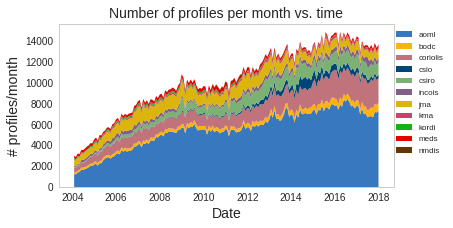

In [46]:
#sns.set_palette("husl")
fig = make_stack_plot(dacTimeSeriesDf)
axes = plt.axes()
axes.legend(bbox_to_anchor=(1.17, 1.00))
plt.savefig(os.path.join(figDir,'dacTS.png'), dpi=200, bbox_inches='tight')

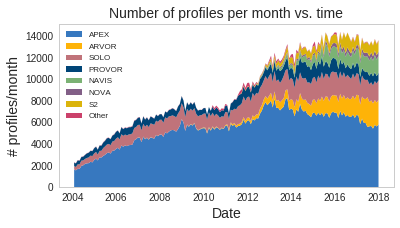

In [47]:
truncTSDF= typeTimeSeriesDf.fillna(0).copy()
tdf = truncTSDF[['date', 'nProf']].copy()
tdf['APEX'] = truncTSDF['APEX'] \
                    + truncTSDF['APEX Profiling Float'] \
                    + truncTSDF['APEX-SBE'] \
                    + truncTSDF['APEX_D']

tdf['ARVOR'] = truncTSDF['ARVOR'] \
                           + truncTSDF['ARVOR_D']
tdf['SOLO'] = truncTSDF['SOLO'] \
                           + truncTSDF['SOLO-W'] \
                           + truncTSDF['SOLO_D'] \
                           + truncTSDF['SOLO_II'] \
                           + truncTSDF['SOLO_W']

tdf['PROVOR'] = truncTSDF['PROVOR'] \
                           + truncTSDF['POPS_PROVOR'] \
                           + truncTSDF['PROVOR-SBE'] \
                           + truncTSDF['PROVOR_CTS3-DO-I'] \
                           + truncTSDF['PROVOR_II'] \
                           + truncTSDF['PROVOR_III'] \
                           + truncTSDF['PROVOR_IV'] \
                           + truncTSDF['PROVOR_MT']

tdf['NAVIS'] = truncTSDF['NAVIS'] \
                           + truncTSDF['NAVISIR'] \
                           + truncTSDF['NAVIS_A']

tdf['NOVA'] = truncTSDF['NOVA'] \
                           + truncTSDF['NOVA-SBE'] \
                           + truncTSDF['Nova-SBE']
                            
tdf['S2'] = truncTSDF['S2A'] \
                  + truncTSDF['S2X']
    
tdf['Other'] =  truncTSDF['Unnamed: 1']\
                +truncTSDF['Usage : ../sh/read_csv_list.sh <']\
                +truncTSDF['Primary sampling: discrete']\
                +truncTSDF['Primary sampling: averaged []']\
                +truncTSDF['HM2000']\
                +truncTSDF['NEMO']\
                +truncTSDF['PALACE']\
                +truncTSDF['ALAMO']\
                +truncTSDF['NINJA'] \
                +truncTSDF['NINJA_D']
                        


truncTSDF.drop(['APEX Profiling Float',
                        'APEX-SBE',
                        'APEX_D', 
                        'ARVOR_D', 
                        'SOLO-W', 
                        'SOLO_W', 
                        'SOLO_D', 
                        'SOLO_II', 
                        'POPS_PROVOR',
                        'PROVOR-SBE',
                        'PROVOR_CTS3-DO-I',
                        'PROVOR_II',
                        'PROVOR_III',
                        'PROVOR_IV',
                        'PROVOR_MT',
                        'S2A',
                        'S2X', 'NOVA-SBE', 'Nova-SBE', 'NAVISIR', 'NAVIS_A', 'NINJA_D'
                        '',
                        'Usage : ../sh/read_csv_list.sh <',
                        'Primary sampling: discrete',
                        'Primary sampling: averaged []'
               ], axis=1, inplace=True)
#sns.set_palette(sns.color_palette("Set2", n_colors=8))
truncTSDF.fillna(0, inplace=True)
fig = make_stack_plot(tdf)
plt.savefig(os.path.join(figDir,'floatTypeTS.png'), dpi=200, bbox_inches='tight')

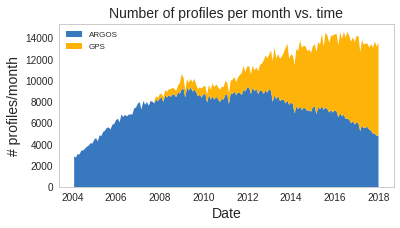

In [50]:
sns.set_palette(sns.xkcd_palette(myColors))
psdf=psTimeSeriesDf
psdf['GPS'] = psTimeSeriesDf['GPS'] + psTimeSeriesDf['IRIDIUM']
#psdf.drop('GTS', axis = 1, inplace=True)
psdf.drop('IRIDIUM', axis = 1, inplace=True)
fig = make_stack_plot(psdf)
plt.savefig(os.path.join(figDir,'posSysTypeTS.png'), dpi=200, bbox_inches='tight')

In [45]:
psTimeSeriesDf['ARGOS'].tail(1)/ ( psTimeSeriesDf['ARGOS'].tail(1) + psTimeSeriesDf['GPS'].tail(1) + psTimeSeriesDf['IRIDIUM'].tail(1))

167    0.364577
dtype: float64

In [46]:
(psTimeSeriesDf['GPS'].tail(1)+ psTimeSeriesDf['IRIDIUM'].tail(1))/ ( psTimeSeriesDf['ARGOS'].tail(1) + psTimeSeriesDf['GPS'].tail(1) + psTimeSeriesDf['IRIDIUM'].tail(1))

167    0.635423
dtype: float64

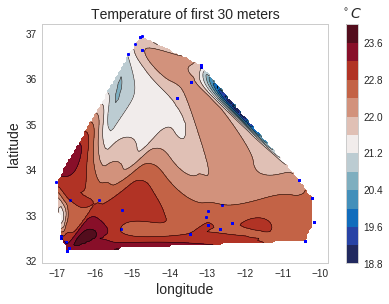

In [18]:
def contourPlot(df):
    fig = plt.figure()
    axes = plt.axes()
    xi = np.linspace(df['lon'].min(),df['lon'].max(),100)
    yi = np.linspace(df['lat'].min(),df['lat'].max(),100)
    
    x = df['lon'].values
    y = df['lat'].values
    z = df['temp'].values
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
    CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
    CS = plt.contourf(xi,yi,zi,15,cmap=cmocean.cm.balance)
    axes.scatter(x,y,marker='o',c='b',s=5)
    axes.set_title('Temperature of first 30 meters')

    axes.set_ylabel('latitude')
    axes.set_xlabel('longitude')
    cbar = fig.colorbar(CS, cmap = cmocean.cm.balance)
    cbar.ax.set_title('$^\circ C$', size=14)
    return fig

fig1 = contourPlot(selectionDf)
plt.savefig(os.path.join(figDir,'worldHist.eps'), dpi=200, bbox_inches='tight')

In [17]:
tsDf = pd.read_csv('gilbralter.csv')
tsDf = tsDf[['tempMean', 'psalMean', 'tempStd', 'psalStd', 'startDate', 'endDate', 'nProf']]
tsDf['startDate'] = pd.to_datetime(tsDf['startDate'])
tsDf['endDate'] = pd.to_datetime(tsDf['endDate'])

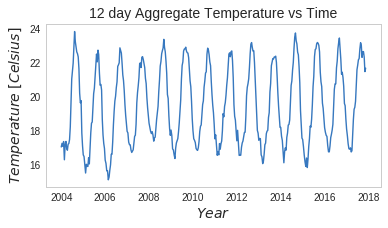

In [18]:
fig = plt.figure(999, figsize=(6,3))
axes = plt.axes()
temp = tsDf['tempMean'].values
time = tsDf['startDate'].values
axes.plot(time, temp)
axes.set_title(r'12 day Aggregate Temperature vs Time')
axes.set_ylabel(r'$Temperature\ [Celsius]$')
axes.set_xlabel(r'$Year$')
plt.savefig(os.path.join(figDir,'ts.png'), dpi=200, bbox_inches='tight')

In [25]:
def get_platform_measurements(profiles):
    '''
    Retrieves all measurements included in a list of platforms.
    '''
    stationParam = []
    for profile in profiles:
        stationParam.append(profile['station_parameters'])
    flatList = [item for sublist in stationParam for item in sublist]
    if isinstance(flatList[0], list):
        flatList = [item for sublist in flatList for item in sublist]
    uniqueList = list(set(flatList))
    uniqueList = [s for s in uniqueList if s != ''] # ignore blank station params.
                
    measurement_keys = [x.lower() for x in uniqueList]   
    return measurement_keys

def get_dates_set(yearstart=2004, yearend=2019, period=30):
    n_rows = int(np.floor(365/period))
    datesSet = []
    for year in range(yearstart, yearend):
        yearSet = np.array_split(pd.date_range(str(year)+'-01-01', str(year)+'-12-31'), n_rows)
        datesSet = datesSet + yearSet
    keepEnds = lambda x: [x[0].strftime(format='%Y-%m-%d'), x[-1].strftime(format='%Y-%m-%d')]
    datesSet = list(map(keepEnds, datesSet))
    return datesSet

def get_ocean_time_series(seriesStartYear,
                          seriesEndYear,
                          seriesStartDate,
                          seriesEndDate,
                          shape,
                          period=30,
                          presRange=[0,30]):
    """Queries argovis database over long time scales but over one shape.
    shape should have a radius of no more than a few degrees.
    Pressure range should about 10-50 dbar.
    """
    
    selectionProfiles = get_selection_profiles(seriesStartDate, seriesEndDate, shape, str(presRange))
    if len(selectionProfiles) == 0:
        return
    meas_keys = get_platform_measurements(selectionProfiles)
    meas_keys = [s for s in meas_keys if s != ''] # ignore profiles that dont report anything
    #print('Selection measurements: {}'.format(meas_keys))
    df = parse_into_df(selectionProfiles)
    
    #provide a time index for date ranges
    datesSet = get_dates_set(seriesStartYear, seriesEndYear, period)
    dateFormat = '%Y-%m-%dT%H:%M:%S.%fZ'
    df['date'] =  pd.to_datetime(df['date'], format=dateFormat)
    for idx, dates in enumerate(datesSet):
        startDate = datetime.strptime(dates[0], '%Y-%m-%d')
        endDate = datetime.strptime(dates[1], '%Y-%m-%d')
        try:
            if df[ (df['date'] < endDate) & (df['date'] > startDate)].shape[0] > 0: # sometimes there aren't any profiles at certain depth intervals
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'tIndex'] = idx
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'startDate'] = startDate
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'endDate'] = endDate
        except ValueError:
            pdb.set_trace()
            df[ (df['date'] < startDate) & (df['date'] > endDate)].shape[0]

    df = df[np.isfinite(df['tIndex'])]
    #df.dropna(axis=1, how='any', inplace=True)
    #group and aggregate over tIndex

    grouped = df.groupby('tIndex')

    groupedList = []
    for tdx, group in grouped:
        nMeas = group.shape[0]
        groupDict = {}
        if nMeas == 0:
            continue
        tempMean = group['temp'][group['temp'] != -999].mean()
        psalMean = group['psal'][group['psal'] != -999].mean()
        tempStd = group['temp'][group['temp'] != -999].std()
        psalStd = group['psal'][group['psal'] != -999].std()
        startDate = group['startDate'].values[0]
        endDate = group['endDate'].values[0]
        groupDict['tempMean'] = tempMean
        groupDict['psalMean'] = psalMean
        groupDict['tempStd'] = tempStd
        groupDict['psalStd'] = psalStd
        groupDict['startDate'] = startDate
        groupDict['endDate'] = endDate
        groupDict['nProf'] = nMeas
        groupDict['lPres'] = presRange[0]
        groupDict['hPres'] = presRange[1]
        groupedList.append(groupDict)
    tsDf = pd.DataFrame(groupedList)
    return tsDf

In [26]:
seriesStartDate='2004-01-01'
seriesEndDate='2018-12-31'
#seriesStartDate='2018-01-01'
#seriesEndDate='2018-04-31'

seriesStartYear = 2004
seriesEndYear = 2019

# shape should be nested array with lon, lat coords.
shape = '[[[-18.6,31.7],[-18.6,37.7],[-5.9,37.7],[-5.9,31.7],[-18.6,31.7]]]'
presIntervals = [[0,10], 
                [10,20], 
                [20,30], 
                [30,40], 
                [40,50], 
                [50,60],
                [60,70], 
                [70,80], 
                [80,90], 
                [90,100]]           
#presIntervals = [str(x) for x in presIntervals]

In [27]:
period = 12
myDir = 'bsts'
dates = get_dates_set(seriesStartYear, seriesEndYear, period)
dates = list(map(lambda date: datetime.strptime(date[0], '%Y-%m-%d'), dates))

depthArray = np.array(presIntervals)

In [28]:
startDepths = depthArray[:,0]

In [29]:
seriesStartYear

2004

In [30]:
for idx, presInterval in enumerate(presIntervals):
    tsDf = get_ocean_time_series(seriesStartYear, seriesEndYear,seriesStartDate, seriesEndDate, shape, period, presRange=presInterval)
    tsDf.index.rename('timeIdx', inplace=True)
    tsDf['depthMin'] = presInterval[0]
    tsDf['depthMax'] = presInterval[1]
    tsDf.to_csv(os.path.join(tsDir,'gilbralter_time_series_at_depth_{}.csv'.format(idx)))

In [32]:
tsDf.head(5)

endDate  hPres  lPres  nProf   psalMean   psalStd  startDate  \
timeIdx                                                                   
0       2004-01-13    100     90      1  36.364918       NaN 2004-01-01   
1       2004-01-26    100     90      1  36.176449       NaN 2004-01-14   
2       2004-02-08    100     90      2  36.374853  0.013803 2004-01-27   
3       2004-02-21    100     90      1  36.350880       NaN 2004-02-09   
4       2004-03-05    100     90      1  36.236725       NaN 2004-02-22   

          tempMean   tempStd  depthMin  depthMax  
timeIdx                                           
0        17.021999       NaN        90       100  
1        15.898000       NaN        90       100  
2        16.860000  0.141421        90       100  
3        16.749001       NaN        90       100  
4        16.045000       NaN        90       100

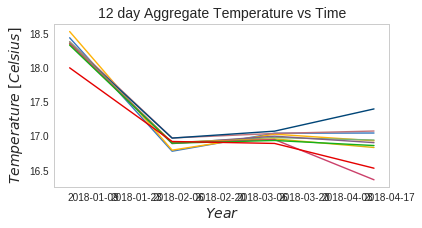

In [32]:
fig = plt.figure(999, figsize=(6,3))
axes = plt.axes()
for idx, presInterval in enumerate(presIntervals):
    tsDf = get_ocean_time_series(seriesStartYear, seriesEndYear, shape, presRange=presInterval)
    tsDf.index.rename('timeIdx', inplace=True)
    tsDf['depthMin'] = presInterval[0]
    tsDf['depthMax'] = presInterval[1]
    tsDf.to_csv(os.path.join(tsDir,'gilbralter_time_series_at_depth_{}.csv'.format(idx)))
    temp = tsDf['tempMean'].values
    time = tsDf['startDate'].values
    axes.plot(time, temp)
axes.set_title(r'12 day Aggregate Temperature vs Time')
axes.set_ylabel(r'$Temperature\ [Celsius]$')
axes.set_xlabel(r'$Year$')

In [54]:
def combine_ts(tsDir):
    df = pd.DataFrame()
    for idx, presInterval in enumerate(presIntervals):
        tsDf = pd.read_csv(os.path.join(tsDir, 'gilbralter_time_series_at_depth_{}.csv'.format(idx)))
        tsDf.index = tsDf['timeIdx']
        tsDf['depthIdx'] = idx
        tsDf['depthMin'] = presInterval[0]
        tsDf['depthMax'] = presInterval[1]
        #tsDf.drop('timeIdx',axis=1, inplace=True)
        df = pd.concat([df, tsDf], axis=0, join='outer')
    return df

def make_ts_color_plot(df, units, pColor, labelDict, seriesStartYear, seriesEndYear, period):
    fig = plt.figure(figsize=(8,4))
    axes = plt.axes()
    #xi = np.linspace(df['timeIdx'].min(),df['timeIdx'].max(),100)
    xi = df['timeIdx'].unique()
    dates = get_dates_set(seriesStartYear, seriesEndYear, period)
    dates = list(map(lambda date: datetime.strptime(date[0], '%Y-%m-%d'), dates))
    #dates = [date.month for date in dates]
    #yi = np.linspace(df['depthIdx'].min(),df['depthIdx'].max(),100)
    yi = np.linspace(df['lPres'].min(),df['lPres'].max(),100)
    x = df['timeIdx'].values
    y = df['lPres'].values
    z = df[pColor].values
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')
    CS = plt.contourf(xi,yi,zi,15,cmap=cmocean.cm.balance)
    axes.set_title(labelDict['title'])
    axes.set_ylabel(labelDict['y'])
    axes.set_xlabel(labelDict['x'])
    axes.invert_yaxis()
    cbar = fig.colorbar(CS, cmap = cmocean.cm.thermal)
    cbar.ax.set_title(units, size=14)

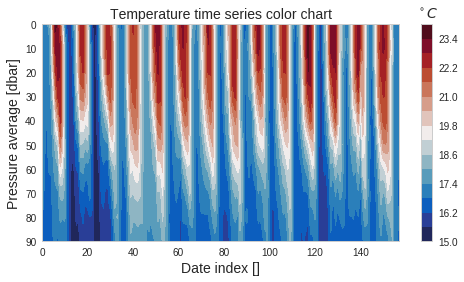

In [55]:
pColor = 'tempMean'
units = '$^\circ C$'
labelDict = {'title': 'Temperature time series color chart', 'y': 'Pressure average [dbar]', 'x': 'Date index []'}
idx = 0

#tsDir = 'bsts'

tsDir = 'gilbralter'
period = 30
df = combine_ts(tsDir)
df.to_csv(os.path.join(tsDir,'gilbralter_time_series_all.csv'))
make_ts_color_plot(df, units, pColor, labelDict, seriesStartYear, seriesEndYear, period)

plt.savefig(os.path.join(figDir,'ts-contour-new.png'), dpi=300, bbox_inches='tight')

In [42]:
def combine_ts_R():
    df = pd.DataFrame()
    for idx, presInterval in enumerate(presIntervals):
        tsDf = pd.read_csv('gilbralter/gilbralter_time_series_at_depth_{}.csv'.format(idx))
        tsDf.index = tsDf['timeIdx']
        tsDf['depthIdx'] = idx
        tsDf['depthMin'] = presInterval[0]
        outColumn = '{}'.format(presInterval[0])
        tsDf[outColumn] = tsDf['tempMean']
        tsDf['depthMax'] = presInterval[1]
        #tsDf.drop('timeIdx',axis=1, inplace=True)
        df = pd.concat([df, tsDf[[outColumn,'startDate']]], axis=1, join='outer')
    return df.T.drop_duplicates().T
dfr = combine_ts_R()
dfr.to_csv('gilbralter/gilbralter_time_series_r.csv')
dfr.head()

0   startDate       10       20       30       40       50  \
timeIdx                                                                     
0        17.1635  2004-01-01  17.1377   17.127  17.1223  17.1167  17.0853   
1        17.1552  2004-02-04  17.0323  17.0065  16.9618  16.9123  16.8617   
2         17.302  2004-03-09   17.124  17.0253   16.929  16.7898  16.7357   
3         17.507  2004-04-12  17.1246     17.1  17.0466   16.983  16.9209   
4         18.605  2004-05-15   18.383   17.914  17.5649  17.2956  17.0433   

              60       70       80       90  
timeIdx                                      
0        17.0397  16.9847   16.838    16.56  
1        16.7943   16.767  16.6508  16.5235  
2        16.6693  16.7568   16.703    16.58  
3        16.8101  16.7373  16.6691  16.5753  
4        16.8413   16.706  16.5406  16.3958

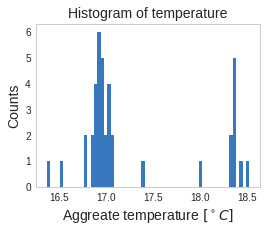

In [73]:
fig2 = plt.figure(2, figsize=(4,3))
axes2 = plt.axes()
axes2.hist(df['tempMean'],60)
axes2.set_title('Histogram of temperature')
axes2.set_ylabel(r'Counts')
axes2.set_xlabel(r'Aggreate temperature $[^\circ C]$')

In [172]:
from scipy import stats
def do_stats(df, col):
    print('Distribution results \n mean: {0}: \n std: {1} \n skew: {2} \n kurtosis: {3} \n'.format(df[col].mean(),
                                                                                                           df[col].std(),
                                                                                                           df[col].skew(),
                                                                                                           df[col].kurtosis()))
    print('median: {0}: \n min: {1} \n max: {2}'.format(df[col].median(),
                                                        df[col].min(),
                                                        df[col].max()))
    skew_test = stats.skewtest(df[col].values)
    kurt_test = stats.kurtosistest(df[col].values)
    print(' kurtosis test p-value: {0} \n skew test p-value: {1}'.format(round(kurt_test.pvalue,4), round(skew_test.pvalue,4)))


In [173]:
df.columns

Index(['timeIdx', 'endDate', 'hPres', 'lPres', 'nProf', 'psalMean', 'psalStd',
       'startDate', 'tempMean', 'tempStd', 'depthIdx'],
      dtype='object')

In [174]:
do_stats(df, 'tempMean')

Distribution results 
 mean: 18.24562056768282: 
 std: 1.9495506118024633 
 skew: 0.8932506916236315 
 kurtosis: -0.1797050770203148 

median: 17.662677029051252: 
 min: 15.094571420124598 
 max: 23.71579996410169
 kurtosis test p-value: 0.1255 
 skew test p-value: 0.0


# Basemap

I am more familiar with Basemap, but its depreciated. Note that in python3 you will have to troubleshoot. Dispite its flaws, you can create some fantastic projections. Below is a scatter plot of our queried data.

In [1]:
monthlyProfilePos = get_monthly_profile_pos(1, 2018)
monthlyDf = parse_pos_into_df(monthlyProfilePos)
monthlyDf.head()
def bin_pos_df(df, delta=1):
    df = df[['_id', 'lat', 'lon']].copy()
    to_bin = lambda x: np.floor(x / delta) * delta
    df["latbin"] = df.lat.map(to_bin)
    df["lonbin"] = df.lon.map(to_bin)
    df.set_index(['latbin', 'lonbin'], inplace=True)
    df['nProf'] = df['_id'].groupby(level=['latbin', 'lonbin']).count()
    return df
binnedDf = bin_pos_df(monthlyDf, 1)
binnedDf.head()

NameError: name 'get_monthly_profile_pos' is not defined

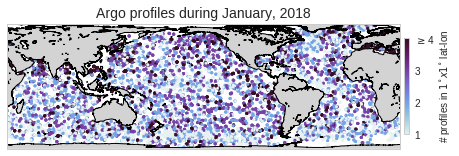

In [162]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_axes([0.001,0.001,0.93,1])
#m = Basemap(projection='cea',llcrnrlat=-90,urcrnrlat=90,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='l')
m = Basemap(projection='cea',lon_0=-145, lat_0 = 50,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='lightgrey')
# draw parallels and meridians.
df = binnedDf

nProf = df.nProf.values
x, y = m(df.lon.values, df.lat.values)
m.scatter(x, y, c=nProf, vmax=4, cmap=cmocean.cm.dense, s=8)
cb = plt.colorbar(location='right', format='%d', fraction=0.012, pad=0.01)
plt.title("Argo profiles during January, 2018".format(startDate, endDate))
cb.set_label('# profiles in $1^{\circ}x1^{\circ}$ lat-lon', size=10)
cb.set_ticks([1, 2,3,4])
cb.set_ticklabels(['1',  '2',  '3',  '$\geq$4'])
plt.savefig(os.path.join(figDir,'worldHist.png'), dpi=200, bbox_inches='tight')

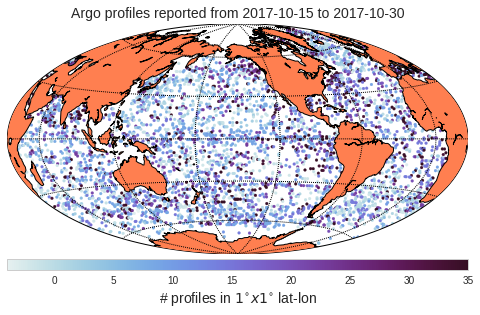

In [28]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
m = Basemap(projection='hammer',lon_0=-150, lat_0 = 50, resolution='c')
m.drawcoastlines()
m.fillcontinents(color='lightgrey')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
df = oceanDf

nProf = df.nProf.values
x, y = m(df.lon.values, df.lat.values)
m.scatter(x, y, c=nProf, vmax=40, cmap=cmocean.cm.dense, s=8)
plt.title("Argo profiles reported from {} to {}".format(startDate, endDate))
#m.colorbar(location='bottom', label='# profiles in 1x1 deg')
cb = m.colorbar(location='bottom', format='%d', fraction=0.036, pad=0.04,  label='# profiles in $1^{\circ}x1^{\circ}$ lat-lon')
cb.set_ticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
cb.set_ticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '$\geq$40'])
plt.show()

For those who want to use pcolormesh...

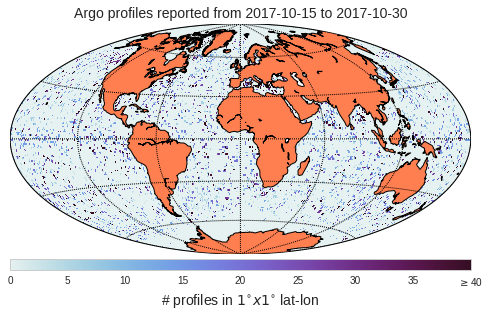

In [29]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
m = Basemap(projection='hammer',lon_0=0, lat_0 = 50, resolution='c')
m.drawcoastlines()
m.fillcontinents(color='lightgrey')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))

df = oceanGrid
df.sort_values(by=['lon', 'lat'], ascending=[True, False], inplace=True)
lons = df['lon'].values
lats = df['lat'].values
x, y = m(lons, lats)
x = x.reshape(180,360)
y = y.reshape(180,360)
z = df['nProf'].values.reshape(180,360)
m.pcolormesh(x, y, z, vmax=40, latlon=False, cmap=cmocean.cm.dense)

plt.title("Argo profiles reported from {} to {}".format(startDate, endDate))
cb = m.colorbar(location='bottom', format='%d', fraction=0.036, pad=0.04, label='# profiles in $1^{\circ}x1^{\circ}$ lat-lon')
cb.set_ticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
cb.set_ticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '$\geq$40'])
plt.show()

Whats nice about using pcolormesh is that you adjust the granularity

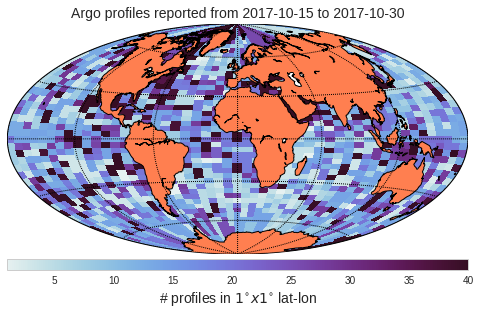

In [30]:
def plot_pcolor_mesh(df, granularity):
    fig = plt.figure(figsize=(8,12))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    m = Basemap(projection='hammer',lon_0=0, lat_0 = 50, resolution='c')
    m.drawcoastlines()
    m.fillcontinents(color='lightgrey')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,120.,30.))
    m.drawmeridians(np.arange(0.,420.,60.))
    df.sort_values(by=['lon', 'lat'], ascending=[True, False], inplace=True)
    x = df['lon'].values
    y = df['lat'].values
    z = df['nProf'].values
    xx, yy = np.mgrid[-180: 180: granularity, -90: 90: granularity]
    zi = griddata((x, y), z, (xx, yy), method='nearest')
    
    xx, yy = m(xx, yy)
    m.pcolormesh(xx, yy, zi, vmax=40, latlon=False, cmap=cmocean.cm.dense)
    plt.title("Argo profiles reported from {} to {}".format(startDate, endDate))
    cb = m.colorbar(location='bottom', format='%d', fraction=0.036, pad=0.04,  label='# profiles in $1^{\circ}x1^{\circ}$ lat-lon')
    return fig

coarse = plot_pcolor_mesh(oceanDf, 50j)

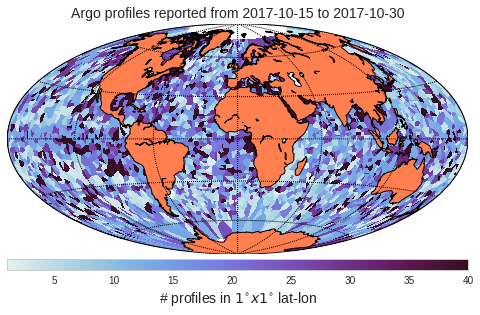

In [31]:
fine = plot_pcolor_mesh(oceanDf, 3000j)

contour, contourf can also be used, but these functions gave me the most trouble. Unfortunatly, Basemap is on its way out. 